In [12]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from common.classification import decision_tree_plot_decision_surfaces
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [13]:
second_sales = "EU_Sales"

# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# choose 7th gen consoles
seventh_gen = ["PS3", "Wii", "X360"]
data = data.loc[data["Platform"].isin(seventh_gen)]

# remove unused columns
columns_used_for_clustering = ["Critic_Score", "NA_Sales", second_sales]
data = data.filter(items=columns_used_for_clustering)

# standardization
standardization = StandardScaler().fit(data[columns_used_for_clustering])
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])

# outlier detection
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

# drop outliers from the dataset
data = drop_outliers_from_dataset(data, outliers)

# de-standardization
data[columns_used_for_clustering] = standardization.inverse_transform(data[columns_used_for_clustering])

### Classification - NA_Sales prediction using other sales and Critic_Score

In [14]:
# create artificial clusters
data["cluster"] = 0
data.loc[data["NA_Sales"] > 0.2, "cluster"] = 1
data.loc[data["NA_Sales"] > 0.7, "cluster"] = 2

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

Number of entries in each cluster:
0    1232
1    1051
2     412
Name: cluster, dtype: int64


### Display clusters and information about them

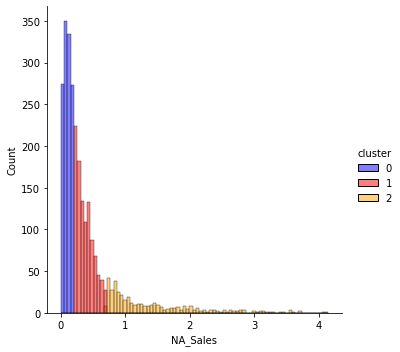

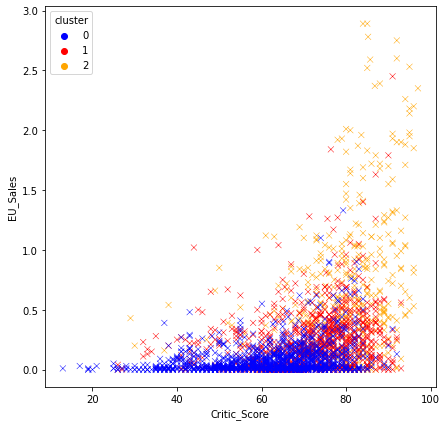

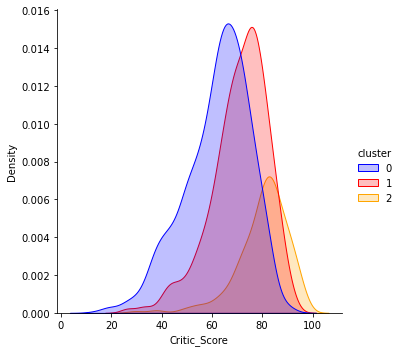

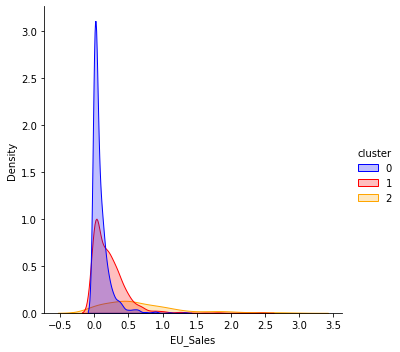

In [15]:
palette = ["blue", "red", "orange"]

sns.displot(data, x="NA_Sales", hue="cluster", palette=palette)
plt.show()

sns.scatterplot(data=data, x="Critic_Score", y=second_sales, hue="cluster", palette=palette, marker='x')
plt.show()

sns.displot(data, x="Critic_Score", hue="cluster", kind="kde", palette=palette, fill=True)
sns.displot(data, x=second_sales, hue="cluster", kind="kde", palette=palette, fill=True)


### Drop column with NA_Sales - it should not be used in the classification, standardize data

In [16]:
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])
data = data.drop(["NA_Sales"], axis=1)

### Split the dataset into training and testing parts for further studies

In [17]:
X = data[["Critic_Score", second_sales]].to_numpy()
Y = data["cluster"].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

training_data = pd.DataFrame(np.concatenate((X_train, np.expand_dims(Y_train, axis=1)), axis=1),
                             columns=["Critic_Score", second_sales, "cluster"])
training_data["cluster"] = training_data["cluster"].astype(int)

testing_data = pd.DataFrame(np.concatenate((X_test, np.expand_dims(Y_test, axis=1)), axis=1),
                            columns=["Critic_Score", second_sales, "cluster"])
testing_data["cluster"] = testing_data["cluster"].astype(int)

### Perform classification using KNN, for different numbers of neighbours

K = 1 - test data score: 0.5343228200371057, training data score: 0.8608534322820037
K = 2 - test data score: 0.5528756957328386, training data score: 0.7523191094619666
K = 3 - test data score: 0.5602968460111317, training data score: 0.7560296846011132
K = 4 - test data score: 0.6029684601113172, training data score: 0.7291280148423006
K = 5 - test data score: 0.6048237476808905, training data score: 0.7175324675324676
K = 6 - test data score: 0.5992578849721707, training data score: 0.6948051948051948
K = 7 - test data score: 0.5899814471243042, training data score: 0.7003710575139147
K = 8 - test data score: 0.5992578849721707, training data score: 0.6859925788497218
K = 9 - test data score: 0.5899814471243042, training data score: 0.6873840445269017
K = 10 - test data score: 0.5936920222634509, training data score: 0.6790352504638218
K = 11 - test data score: 0.5788497217068646, training data score: 0.6776437847866419
K = 12 - test data score: 0.5918367346938775, training data sco

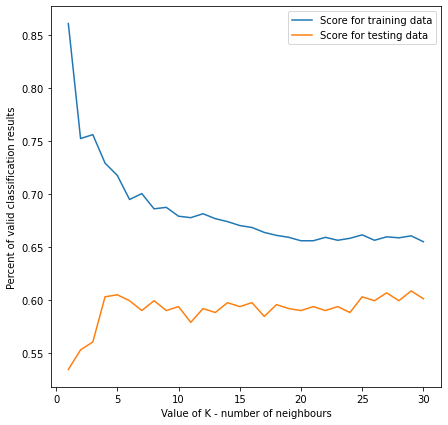

In [18]:
accuracy_test = []
accuracy_train = []
for number_of_neighbours in range(1, 31):
    classifier = KNeighborsClassifier(n_neighbors=number_of_neighbours)\
        .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
    train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    print("K = {} - test data score: {}, training data score: {}".format(number_of_neighbours, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Value of K - number of neighbours")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 31), accuracy_train, label="Score for training data")
plt.plot(range(1, 31), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using KNN, for K = 15

Accuracy for testing data: 0.5936920222634509
Accuracy for training data: 0.6702226345083488


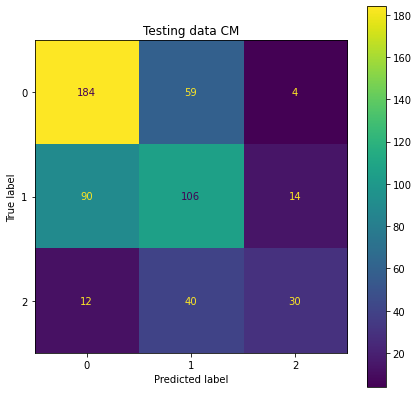

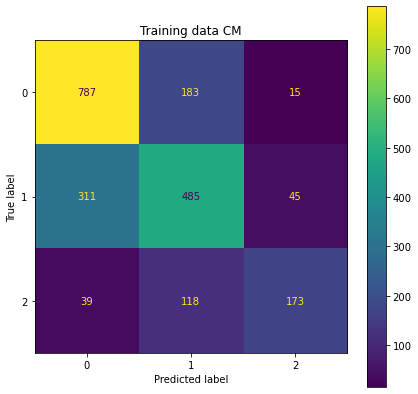

In [19]:
classifier = KNeighborsClassifier(n_neighbors=15)\
    .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

accuracy_test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.title("Training data CM")
plt.show()

### Perform classification using decision tree for different max depths

Max depth = 1 - test data score: 0.5565862708719852, training data score: 0.577922077922078
Max depth = 2 - test data score: 0.588126159554731, training data score: 0.6280148423005566
Max depth = 3 - test data score: 0.6066790352504638, training data score: 0.6428571428571429
Max depth = 4 - test data score: 0.6048237476808905, training data score: 0.6553803339517625
Max depth = 5 - test data score: 0.5918367346938775, training data score: 0.6655844155844156
Max depth = 6 - test data score: 0.5825602968460112, training data score: 0.6859925788497218
Max depth = 7 - test data score: 0.5825602968460112, training data score: 0.6966604823747681
Max depth = 8 - test data score: 0.5788497217068646, training data score: 0.7166048237476809
Max depth = 9 - test data score: 0.5769944341372912, training data score: 0.7365491651205937
Max depth = 10 - test data score: 0.5732838589981447, training data score: 0.7527829313543599


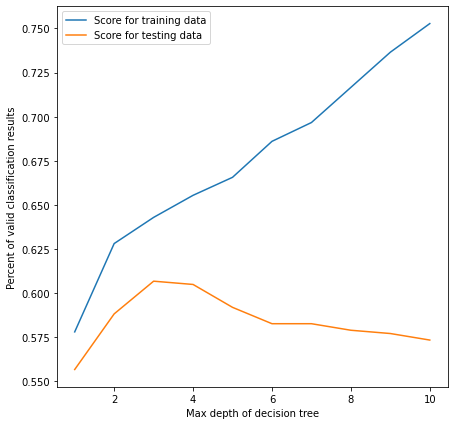

In [20]:
accuracy_test = []
accuracy_train = []
for max_depth in range(1, 11):
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth)\
        .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
    train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    print("Max depth = {} - test data score: {}, training data score: {}".format(max_depth, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Max depth of decision tree")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 11), accuracy_train, label="Score for training data")
plt.plot(range(1, 11), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using decision tree for max depth = 3

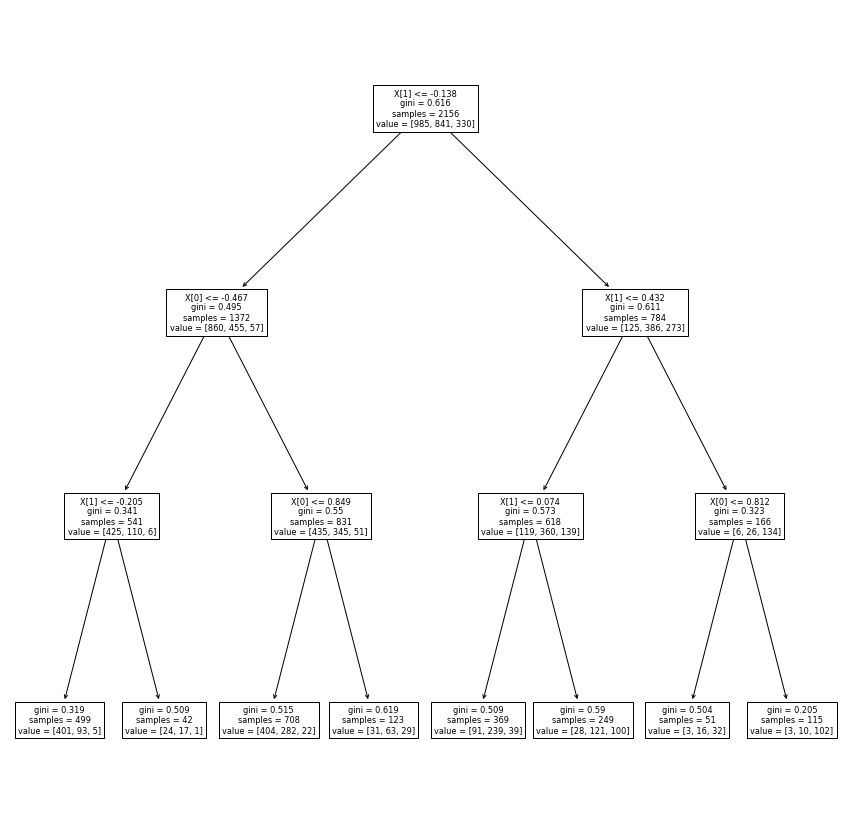

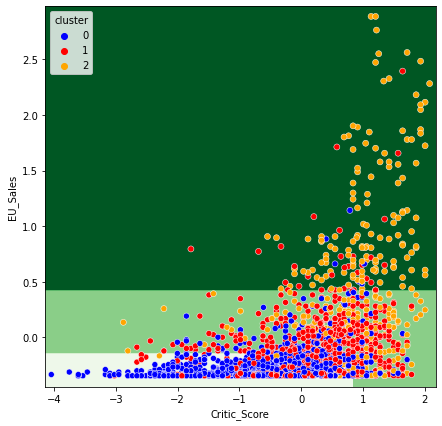

Accuracy for testing data: 0.6066790352504638
Accuracy for training data: 0.6428571428571429


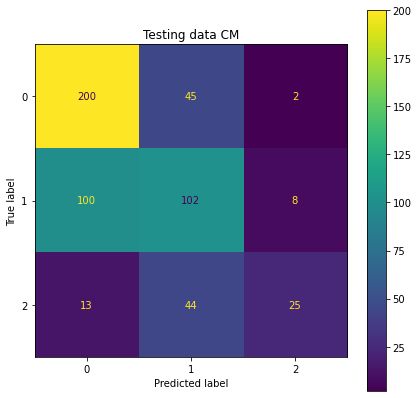

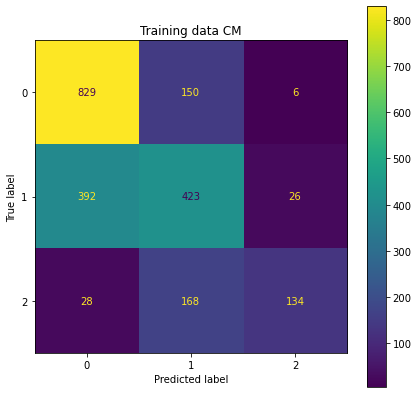

In [21]:
# Note: reducing the depth of this tree has no significant impact on the testing score - only on the training
# score (and even there the impact is not that big) - this is because the tree is "over-fitting"
classifier = tree.DecisionTreeClassifier(max_depth=3)\
    .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.figure(figsize=(15, 15))
tree.plot_tree(classifier)
plt.show()
decision_tree_plot_decision_surfaces(classifier, training_data, ("Critic_Score", second_sales), palette)
plt.show()

accuracy_test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.title("Training data CM")
plt.show()

### Perform classification using kernel density estimators

#### Use cross-validation to get proper bandwidths

In [22]:
bandwidths_for_classes = []
for cl in range(0, 3):

    tr_data = training_data[training_data["cluster"] == cl]
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
    grid.fit(tr_data[["Critic_Score", second_sales]])
    bandwidths_for_classes.append(grid.best_params_["bandwidth"])
    print("Bandwidth for class {}: {}".format(cl, grid.best_params_["bandwidth"]))

Bandwidth for class 0: 0.1
Bandwidth for class 1: 0.12045035402587821
Bandwidth for class 2: 0.1592282793341092


#### Plot resulting KDEs

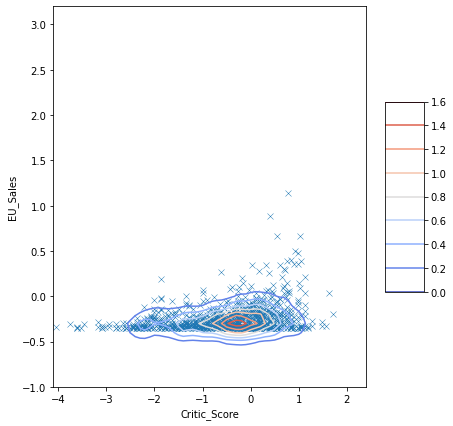

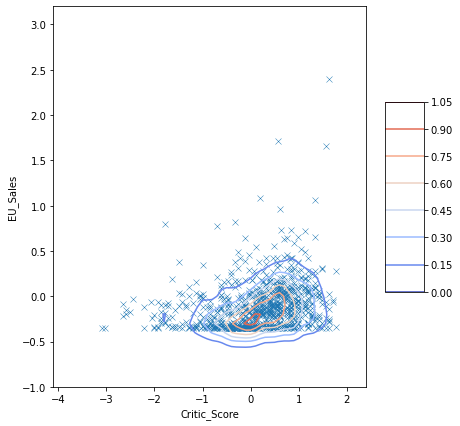

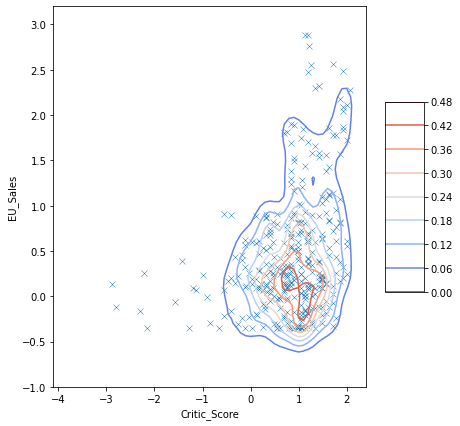

In [23]:
for cl in range(0, 3):

    tr_data = training_data[training_data["cluster"] == cl]
    kde = KernelDensity(bandwidth=bandwidths_for_classes[cl], kernel="gaussian")\
        .fit(tr_data[["Critic_Score", second_sales]])

    X = np.arange(-4.1, 2.5, 0.1).tolist()
    Y = np.arange(-1, 3.3, 0.1).tolist()
    X, Y = np.meshgrid(X, Y)

    inp = np.vstack((X.ravel(), Y.ravel())).T

    result = np.exp(kde.score_samples(inp))
    result = np.reshape(result, X.shape)

    fig = plt.figure()
    sns.scatterplot(data=tr_data, x="Critic_Score", y=second_sales, marker='x')
    p = plt.contour(X, Y, result, cmap='coolwarm')
    fig.colorbar(p, shrink=0.5, aspect=5)
    plt.show()

#### Prepare KDEs objects

In [24]:
tr_data_cl0 = training_data[training_data["cluster"] == 0]
kde_cl0 = KernelDensity(bandwidth=bandwidths_for_classes[0], kernel="gaussian")\
    .fit(tr_data_cl0[["Critic_Score", second_sales]])

tr_data_cl1 = training_data[training_data["cluster"] == 1]
kde_cl1 = KernelDensity(bandwidth=bandwidths_for_classes[1], kernel="gaussian")\
    .fit(tr_data_cl1[["Critic_Score", second_sales]])

tr_data_cl2 = training_data[training_data["cluster"] == 2]
kde_cl2 = KernelDensity(bandwidth=bandwidths_for_classes[2], kernel="gaussian")\
    .fit(tr_data_cl2[["Critic_Score", second_sales]])

#### Perform classification - training dataset

In [25]:
correct_classifications = 0
kde_cl0_scores = np.exp(kde_cl0.score_samples(training_data[["Critic_Score", second_sales]]))
kde_cl1_scores = np.exp(kde_cl1.score_samples(training_data[["Critic_Score", second_sales]]))
kde_cl2_scores = np.exp(kde_cl2.score_samples(training_data[["Critic_Score", second_sales]]))

for index, row in training_data.iterrows():
    scores = [kde_cl0_scores[index], kde_cl1_scores[index], kde_cl2_scores[index]]
    max_index = scores.index(max(scores))
    if max_index == row["cluster"]:
        correct_classifications += 1

print(correct_classifications / len(training_data.index))



0.6340445269016698


#### Perform classification - testing dataset

In [26]:
correct_classifications = 0
kde_cl0_scores = np.exp(kde_cl0.score_samples(testing_data[["Critic_Score", second_sales]]))
kde_cl1_scores = np.exp(kde_cl1.score_samples(testing_data[["Critic_Score", second_sales]]))
kde_cl2_scores = np.exp(kde_cl2.score_samples(testing_data[["Critic_Score", second_sales]]))

for index, row in testing_data.iterrows():
    scores = [kde_cl0_scores[index], kde_cl1_scores[index], kde_cl2_scores[index]]
    max_index = scores.index(max(scores))
    if max_index == row["cluster"]:
        correct_classifications += 1

print(correct_classifications / len(testing_data.index))



0.614100185528757
